In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd
%matplotlib notebook

In [2]:
vector_data = np.loadtxt("vectorgeom-01052014.csv", delimiter=',')
ow_data = np.loadtxt("ow-01052014.csv", delimiter=',')
normal_data = np.loadtxt("normal-01052014.csv", delimiter=',')
winding_data = np.loadtxt("windingangle-01052014.csv", delimiter=',')

real_data = pd.read_csv("validation_data/01052014.csv")
real_data = real_data[["Lat","Lon"]].to_numpy()
real_data = real_data[(real_data[:,1] > -30) & (real_data[:,1] < -20) & (real_data[:,0] > 20) & (real_data[:,0] < 60)]
print(real_data)

[[ 45.74766207 -29.81501637]
 [ 54.23161192 -29.81823487]
 [ 23.96590157 -29.4745845 ]
 [ 40.0602014  -29.33744292]
 [ 59.89574302 -29.4544539 ]
 [ 28.43535032 -29.20951792]
 [ 31.85409676 -28.86390434]
 [ 35.9737873  -29.03369706]
 [ 38.00517313 -28.78413629]
 [ 56.22594967 -28.84158854]
 [ 47.38629658 -28.51422214]
 [ 25.23203752 -28.22224475]
 [ 51.75798351 -28.39062069]
 [ 21.36524349 -27.93492587]
 [ 37.43139773 -27.52467735]
 [ 53.15242789 -27.45309955]
 [ 44.56228388 -27.18828034]
 [ 31.18796261 -26.99689937]
 [ 54.89572356 -26.9563776 ]
 [ 22.16597827 -26.88734038]
 [ 41.89934394 -26.68018756]
 [ 48.21777444 -26.44086887]
 [ 53.49623452 -26.39895716]
 [ 24.93053522 -26.2365122 ]
 [ 29.32420071 -26.2456986 ]
 [ 44.71485577 -26.2327944 ]
 [ 33.51641555 -26.09545245]
 [ 59.01174033 -25.91989471]
 [ 23.50393502 -25.56819624]
 [ 55.71294915 -25.5129798 ]
 [ 20.29403967 -25.04284942]
 [ 48.67924656 -24.75441837]
 [ 38.52381134 -24.5119477 ]
 [ 52.19863332 -24.80380494]
 [ 57.30878128

<IPython.core.display.Javascript object>


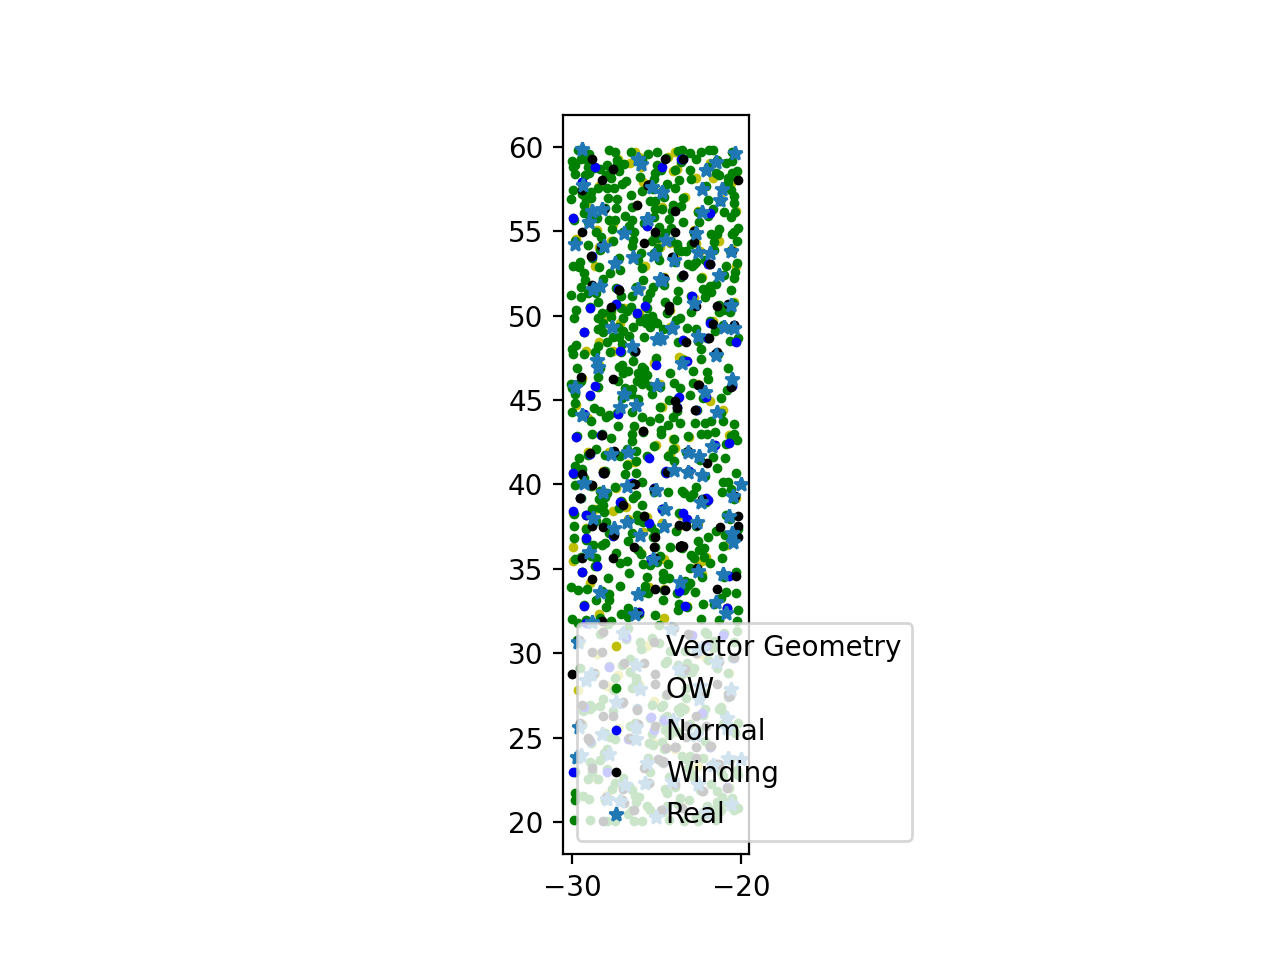

In [3]:
plt.figure(dpi=200)
plt.plot(vector_data[:,1],vector_data[:,0],'y.', markersize=5, label='Vector Geometry')
plt.plot(ow_data[:,1],ow_data[:,0],'g.', markersize=5, label='OW')
plt.plot(normal_data[:,1],normal_data[:,0],'b.', markersize=5, label='Normal')
plt.plot(winding_data[:,1],winding_data[:,0],'k.', markersize=5, label='Winding')
plt.plot(real_data[:,1],real_data[:,0],'*', markersize=5, label='Real')
plt.gca().set_aspect('equal')
plt.legend()

In [4]:
from dataclasses import dataclass

from scipy.spatial import KDTree
from sklearn.metrics.pairwise import haversine_distances

@dataclass
class Method:
    name: str
    points: np.ndarray
    P: int = 0
    TP: int = 0
    FP: int = 0
        
    def compare(self, ground_truth: np.ndarray, dist_tol):
        '''dist_tol is in km'''
        self.P = ground_truth.shape[0]
        
        tree_detected = KDTree(self.points)
        dist, index = tree_detected.query(ground_truth[:,0:2])
        truth = np.deg2rad(ground_truth[:,0:2])
        detected = np.deg2rad(self.points[index,:])
        dist_mat = haversine_distances(truth, detected)
        dist = np.diagonal(dist_mat) * 6371000/1000  # multiply by Earth radius to get kilometers
        
        self.TP = (dist < dist_tol).sum()
        self.dist = dist[dist < dist_tol]
        self.mean_error = np.mean(dist[dist < dist_tol])
        self.FN = self.P - self.TP
        
        tree_truth = KDTree(ground_truth[:,0:2])
        dist, index = tree_truth.query(self.points)
        detected = np.deg2rad(ground_truth[index,0:2])
        dist_mat = haversine_distances(truth, detected)
        dist = np.diagonal(dist_mat) * 6371000/1000  # multiply by Earth radius to get kilometers
                
        self.FP = (dist > dist_tol).sum()
    
    @property
    def TPR(self):
        return self.TP/self.P
    
    @property
    def FDR(self):
        return self.FP/(self.FP + self.TP)
    
    @property
    def F1(self):
        return self.TP/(self.TP + 0.5*(self.FP + self.FN))

    
tol = 50 #km THIS IS UP FOR DEBATE!
methods = [Method("Improved Okubo–Weiss\nParameter Method", ow_data), Method("Vector Geometry\nMethod", vector_data),
           Method("Winding Angle\nMethod", winding_data), 
           Method("Velocity Vector\nNormal Method", normal_data)]

for method in methods:
    method.compare(real_data, tol)
    print(f"{method.name=}, {method.TPR=:.3f}, {method.FDR=:.3f}, {method.mean_error=:.3f}, {method.F1=:.3f}")

method.name='Improved Okubo–Weiss\nParameter Method', method.TPR=0.896, method.FDR=0.528, method.mean_error=23.087, method.F1=0.619
method.name='Vector Geometry\nMethod', method.TPR=0.679, method.FDR=0.590, method.mean_error=23.396, method.F1=0.511
method.name='Winding Angle\nMethod', method.TPR=0.448, method.FDR=0.691, method.mean_error=23.752, method.F1=0.366
method.name='Velocity Vector\nNormal Method', method.TPR=0.254, method.FDR=0.746, method.mean_error=30.284, method.F1=0.254


In [5]:
real_data_val = pd.read_csv("validation_data/01052014.csv")
real_data_val = real_data_val[["Lat","Lon"]].to_numpy()
real_data_val = real_data_val[(real_data_val[:,1] > -30) & (real_data_val[:,1] < -20) & (real_data_val[:,0] > 20) & (real_data_val[:,0] < 60)]
vector_data_val = np.loadtxt("vectorgeom-20042014.csv", delimiter=',')
ow_data_val = np.loadtxt("ow-20042014.csv", delimiter=',')
normal_data_val = np.loadtxt("normal-20042014.csv", delimiter=',')
winding_data_val = np.loadtxt("windingangle-20042014.csv", delimiter=',')

methods_val = [Method("Improved Okubo–Weiss\nParameter Method", ow_data_val),
               Method("Vector Geometry\nMethod",vector_data_val), Method("Winding Angle\nMethod", winding_data_val), 
           Method("Velocity Vector\nNormal Method", normal_data_val)]

for method in methods_val:
    method.compare(real_data_val, tol)
    print(f"{method.name=}, {method.TPR=:.3f}, {method.FDR=:.3f}, {method.mean_error=:.3f}, {method.F1=:.3f}")

method.name='Improved Okubo–Weiss\nParameter Method', method.TPR=0.873, method.FDR=0.532, method.mean_error=25.949, method.F1=0.609
method.name='Vector Geometry\nMethod', method.TPR=0.612, method.FDR=0.619, method.mean_error=30.850, method.F1=0.470
method.name='Winding Angle\nMethod', method.TPR=0.276, method.FDR=0.784, method.mean_error=28.585, method.F1=0.243
method.name='Velocity Vector\nNormal Method', method.TPR=0.216, method.FDR=0.784, method.mean_error=29.949, method.F1=0.216


# Performance on tuning data

In [6]:
data = np.array([methods, methods_val]).flatten("F")

<IPython.core.display.Javascript object>


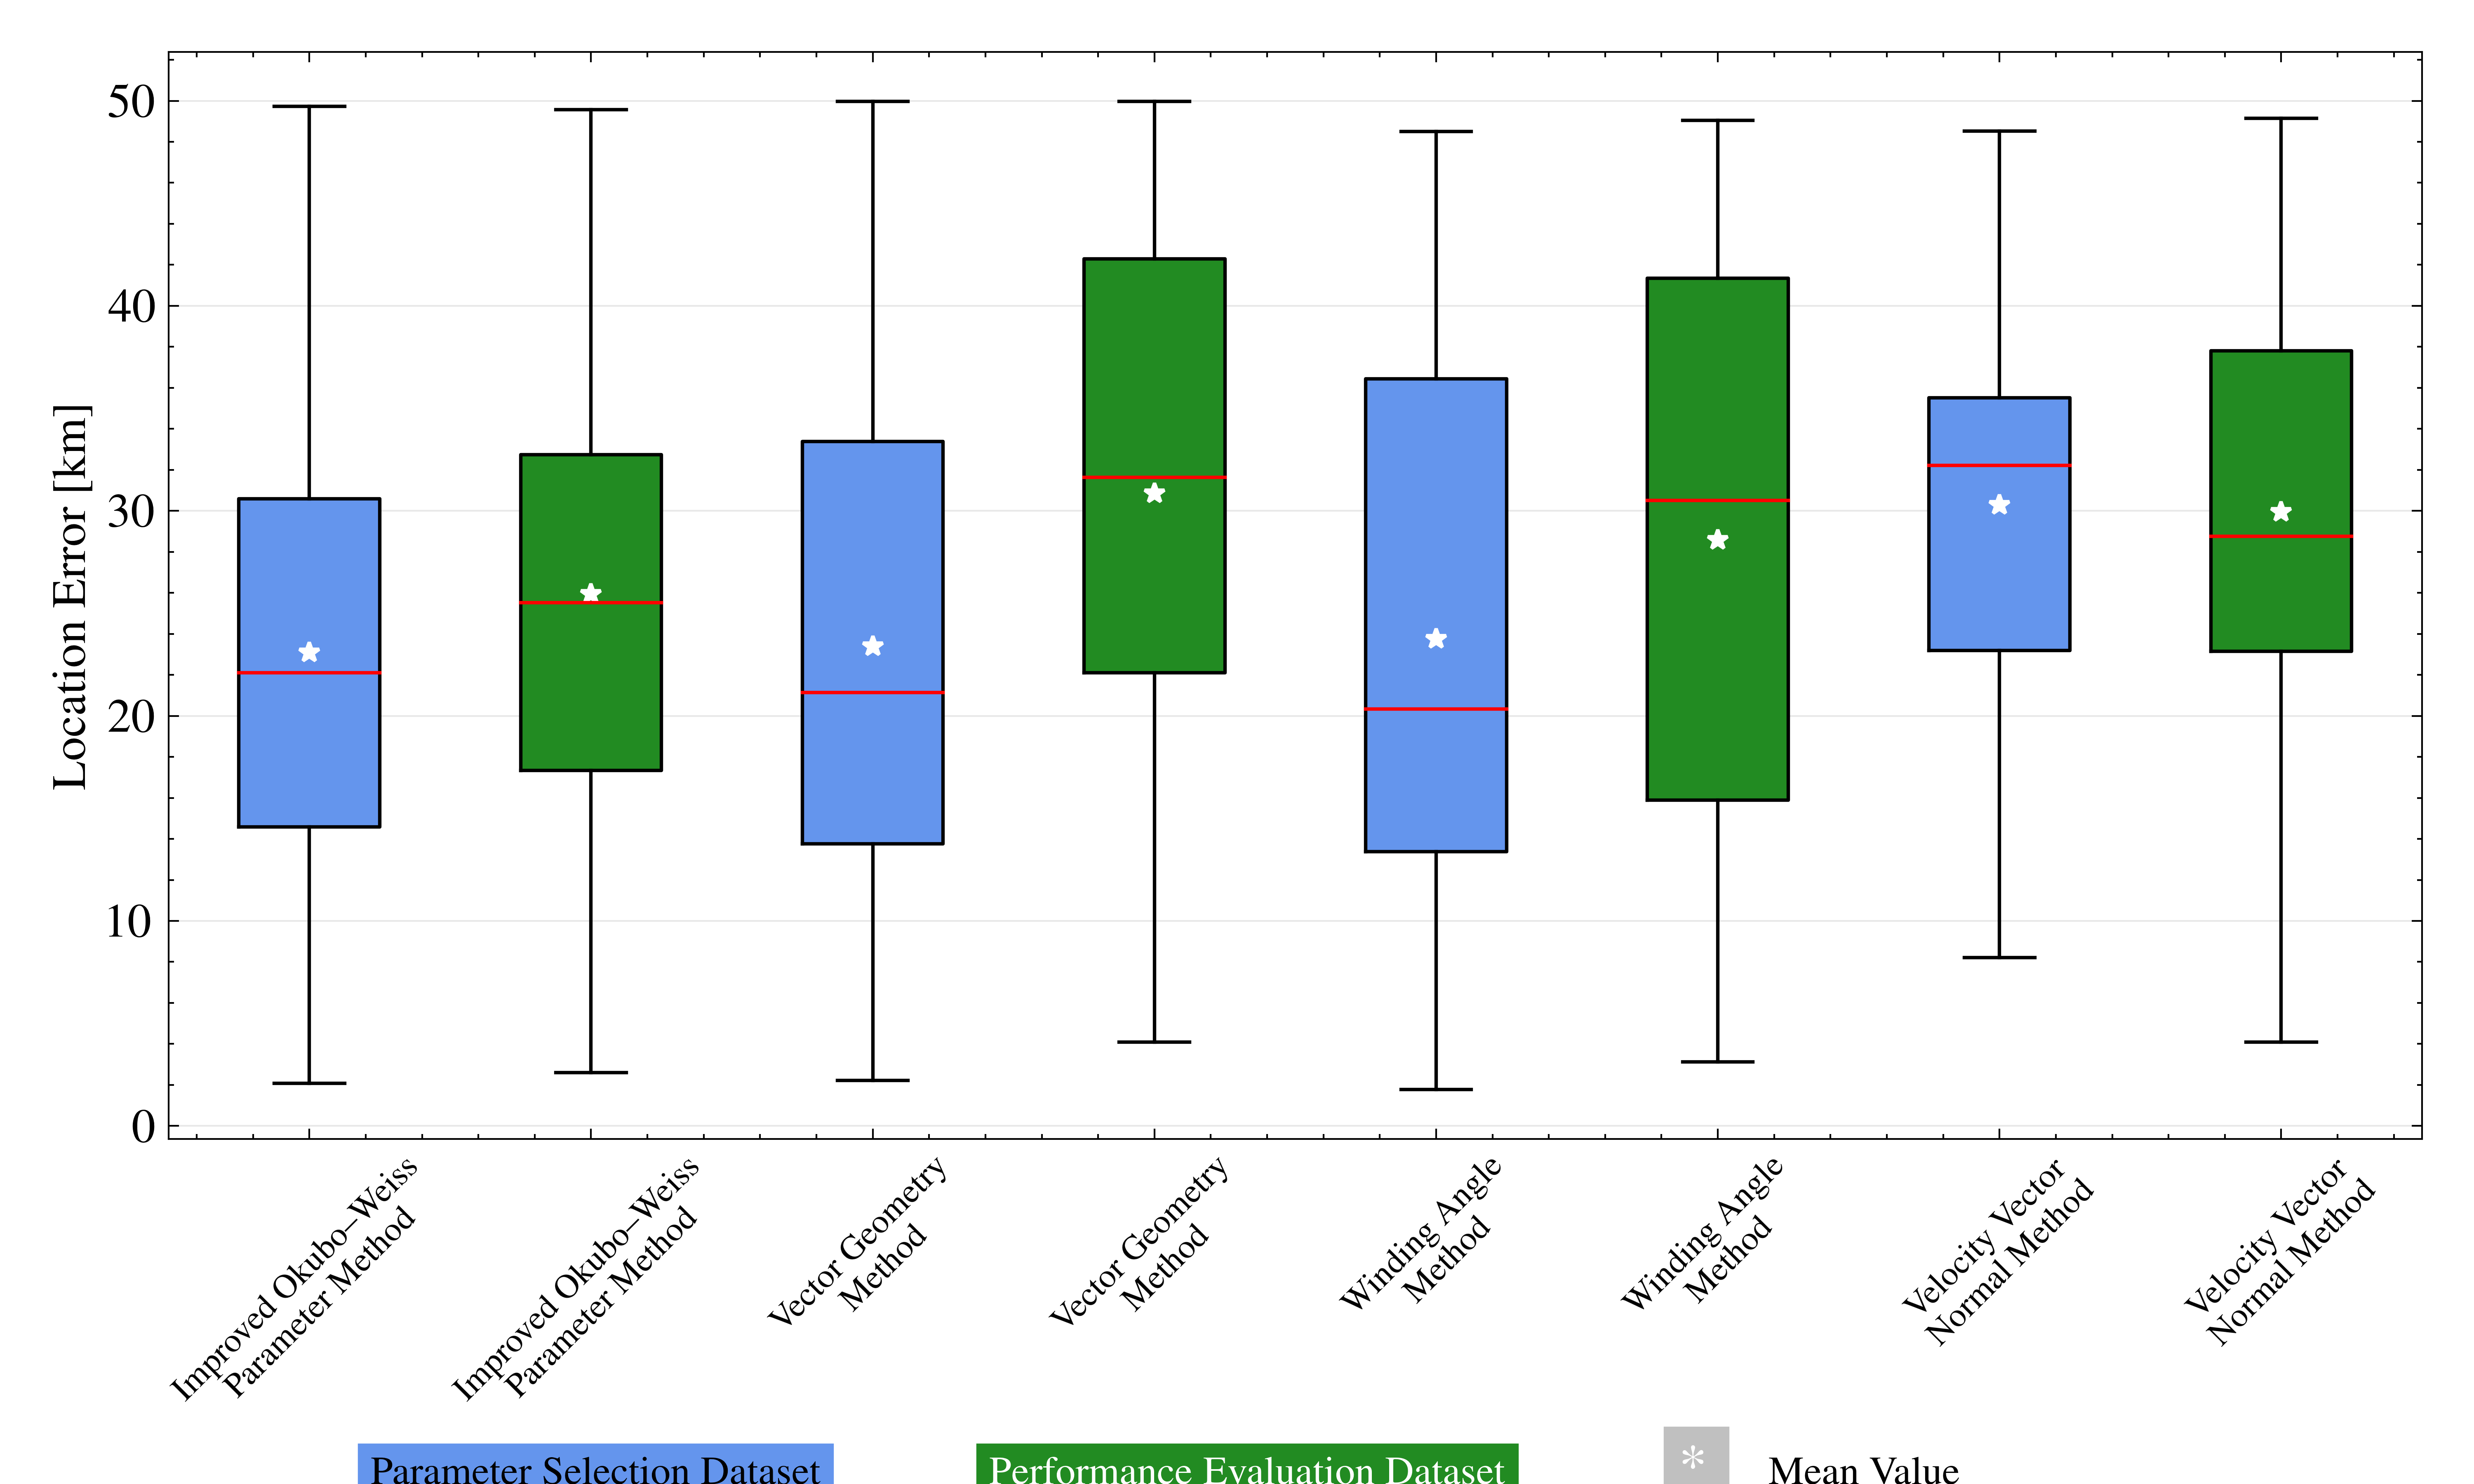

In [7]:
plt.style.use(['science','ieee'])
plt.rcParams.update({'font.size': 14})
from matplotlib.patches import Polygon

fig, ax1 = plt.subplots(figsize=(10, 6))
bp = ax1.boxplot([method.dist for method in data])
ax1.set_ylabel("Location Error [km]")
ax1.set_xticklabels([method.name for method in data],
                    rotation=45, fontsize=10)
ax1.set_axisbelow(True)
ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

# Now fill the boxes with desired colors
box_colors = ['cornflowerblue', 'forestgreen']
num_boxes = len(data)
medians = np.empty(num_boxes)
for i in range(num_boxes):
    box = bp['boxes'][i]
    box_x = []
    box_y = []
    for j in range(5):
        box_x.append(box.get_xdata()[j])
        box_y.append(box.get_ydata()[j])
    box_coords = np.column_stack([box_x, box_y])
    # Alternate between Dark Khaki and Royal Blue
    ax1.add_patch(Polygon(box_coords, facecolor=box_colors[i % 2]))
    # Now draw the median lines back over what we just filled in
    med = bp['medians'][i]
    # Finally, overplot the sample averages, with horizontal alignment
    # in the center of each box
    ax1.plot(np.average(med.get_xdata()), np.average(data[i].dist),
             color='w', marker='*',)
    
ax1.set_xlim(0.5, num_boxes + 0.5)
    
# Finally, add a basic legend
fig.text(0.15, 0.0, f'Parameter Selection Dataset',
         backgroundcolor=box_colors[0], color='black', weight='roman',
         size='small')
fig.text(0.40, 0.0, 'Performance Evaluation Dataset',
         backgroundcolor=box_colors[1],
         color='white', weight='roman', size='small')
fig.text(0.68, 0.0, '*', color='white', backgroundcolor='silver',
         weight='roman', size='large')
fig.text(0.715, 0.0, ' Mean Value', color='black', weight='roman',
         size='small')


fig.tight_layout()
plt.savefig("figures/boxplot.pdf",bbox_inches='tight')

<IPython.core.display.Javascript object>


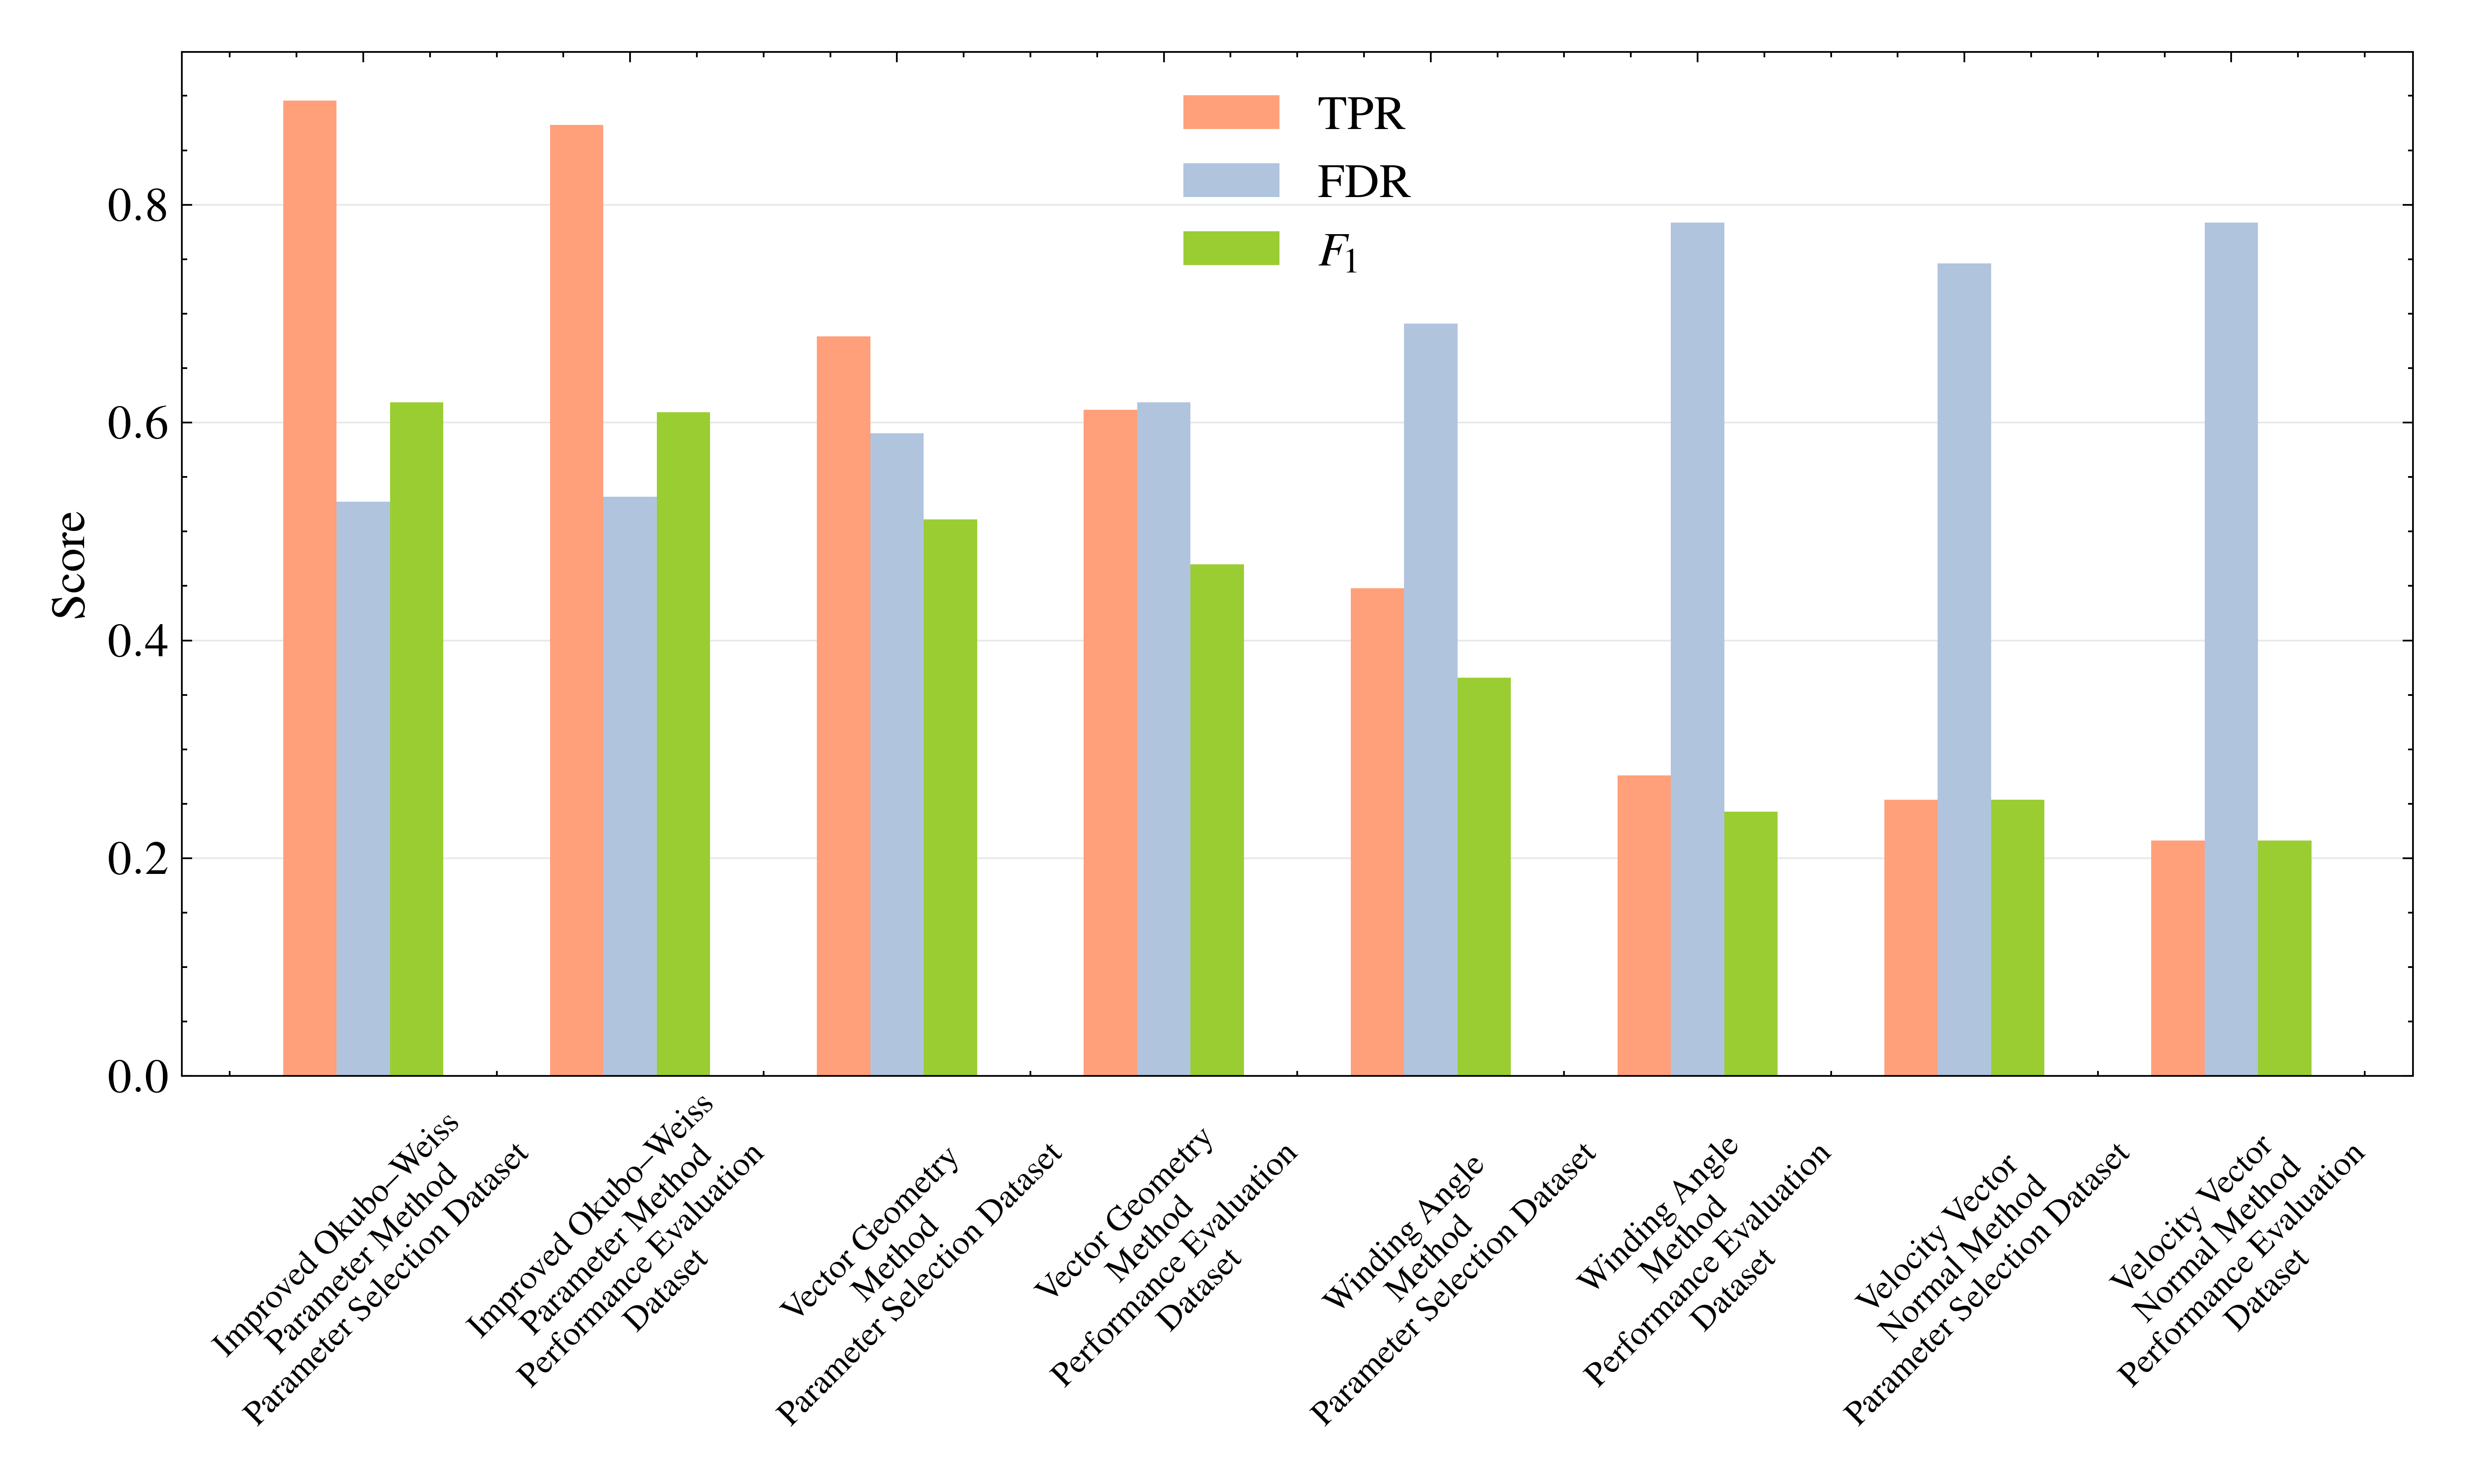

In [8]:
labels = [method.name for method in data]
for i, label in enumerate(labels):
    if i % 2 == 0:
        labels[i] = label + "\nParameter Selection Dataset"
    else:
        labels[i] = label + "\nPerformance Evaluation\nDataset"
TPR = [method.TPR for method in data]
FDR = [method.FDR for method in data]
F1 = [method.F1 for method in data]


x = 2*np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars



fig, ax = plt.subplots(figsize=(10, 6))
ax.set_axisbelow(True)
ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',alpha=0.5)
rects2 = ax.bar(x - width, TPR, width, label='TPR', color="lightsalmon")
rects1 = ax.bar(x, FDR, width, label='FDR', color="lightsteelblue")
rects3 = ax.bar(x + width, F1, width, label='$F_1$', color="yellowgreen")
ax.set_xticks(x, labels, rotation=45, fontsize=10)
ax.set_ylabel("Score")

ax.legend()
fig.tight_layout()
plt.savefig("figures/barplot.pdf",bbox_inches='tight')